In [1]:
from datasets import list_datasets

all_datasets = list_datasets()
print(f"There are {len(all_datasets)} datasets available on the Hub.\nThe first 10 are{all_datasets[:10]}")

/var/folders/37/k13vl33513q2fjyh_xjdk2k80000gn/T/ipykernel_952/1552698497.py:3: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets = list_datasets()


There are 168749 datasets available on the Hub.
The first 10 are['amirveyseh/acronym_identification', 'ade-benchmark-corpus/ade_corpus_v2', 'UCLNLP/adversarial_qa', 'Yale-LILY/aeslc', 'nwu-ctext/afrikaans_ner_corpus', 'fancyzhx/ag_news', 'allenai/ai2_arc', 'google/air_dialogue', 'komari6/ajgt_twitter_ar', 'legacy-datasets/allegro_reviews']


In [2]:
from datasets import load_dataset

emotions = load_dataset("emotion")
print(emotions)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


In [3]:
train_ds = emotions['train']
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [4]:
len(train_ds)

16000

In [5]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [6]:
train_ds.column_names

['text', 'label']

In [7]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [8]:
train_ds[:5]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': [0, 0, 3, 2, 3]}

In [9]:
train_ds['text'][:5]

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong',
 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'i am feeling grouchy']

### Dataset loading using URL

In [10]:
import requests

dataset_url = "https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt?dl=1"
response = requests.get(dataset_url)

with open("train.txt", "wb") as file:
    file.write(response.content)

print("File downloaded successfully")

File downloaded successfully


In [11]:
emotions_local = load_dataset("csv", data_files="train.txt", sep=";", names=["text", "label"])
emotions_local

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 31
    })
})

### From Datasets to Dataframes

In [12]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [13]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### Looking at the class distribution

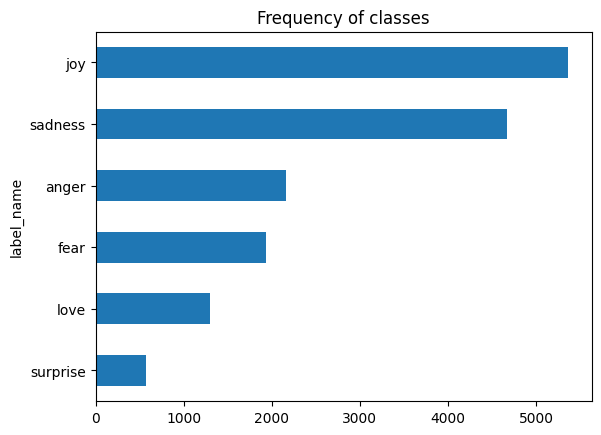

In [14]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of classes")
plt.show()

### How long are our tweets?

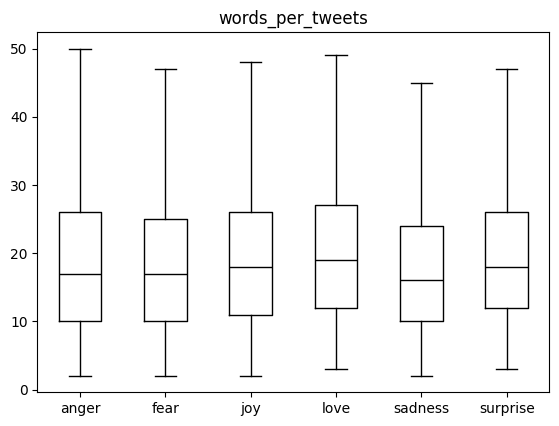

In [15]:
df["words_per_tweets"] = df["text"].str.split().apply(len)
df.boxplot("words_per_tweets", by="label_name", grid=False, showfliers=False, color="black")

plt.suptitle("")
plt.xlabel("")
plt.show()

In [16]:
emotions.set_format() # suitable format for transformers

### From text to tokens
### Character tokanization

In [17]:
text = "I love transformers"
tokenized_text = list(text)
print(tokenized_text)

['I', ' ', 'l', 'o', 'v', 'e', ' ', 't', 'r', 'a', 'n', 's', 'f', 'o', 'r', 'm', 'e', 'r', 's']


In [18]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, 'I': 1, 'a': 2, 'e': 3, 'f': 4, 'l': 5, 'm': 6, 'n': 7, 'o': 8, 'r': 9, 's': 10, 't': 11, 'v': 12}


In [19]:
input_idx = [token2idx[token] for token in tokenized_text]
print(input_idx)

[1, 0, 5, 8, 12, 3, 0, 11, 9, 2, 7, 10, 4, 8, 9, 6, 3, 9, 10]


In [20]:
# one-hot encoding
cat_df = pd.DataFrame({
    "Name":["A", "B", "C"],
    "Label":[1,2,3]
})
cat_df

,Name,Label
0,A,1
1,B,2
2,C,3


In [21]:
pd.get_dummies(cat_df['Name'])

,A,B,C
0,True,False,False
1,False,True,False
2,False,False,True


In [22]:
import torch
import torch.nn.functional as F

input_idx = torch.tensor(input_idx)

one_hot_encodings = F.one_hot(input_idx, num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([19, 13])

In [23]:
print(f"Token: {tokenized_text[0]}")
print(f"Tensor index: {input_idx[0]}")
print(f"One-hot: {one_hot_encodings[0]}")

Token: I
Tensor index: 1
One-hot: tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


### Word Tokenization

In [24]:
tokenized_text = text.split()
tokenized_text

['I', 'love', 'transformers']

### Subword Tokenization

In [25]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [26]:
encoded_text = tokenizer(text)
encoded_text

{'input_ids': [101, 1045, 2293, 19081, 102], 'attention_mask': [1, 1, 1, 1, 1]}

In [27]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
tokens

['[CLS]', 'i', 'love', 'transformers', '[SEP]']

In [28]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] i love transformers [SEP]


In [29]:
tokenizer.vocab_size

30522

In [30]:
tokenizer.model_max_length

512

In [31]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

### Tokenizing the whole dataset

In [32]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [33]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [34]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

In [35]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


### Training a text classifier
### Transformers as Feature Extraction
#### Using pretrained models

In [36]:
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [37]:
print(f"Model loaded on {device}")

Model loaded on cpu


### Extracting the last hidden states

In [38]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")

print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


In [39]:
inputs = {k:v.to(device) for k,v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)

print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]]), hidden_states=None, attentions=None)


In [40]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

In [41]:
def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    return {"hidden_state":last_hidden_state[:,0].cpu().numpy()}

In [42]:
emotions_encoded.set_format("torch", columns=["input_ids","attention_mask", "label"])
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

In [43]:
emotions_hidden["train"]

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
    num_rows: 16000
})

In [44]:
# creating feature matrix

import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])

X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

#### Visualizing the training set

In [45]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

In [46]:
X_scaled = MinMaxScaler().fit_transform(X_train)
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)

df_emb = pd.DataFrame(mapper.embedding_, columns=["X","Y"])
df_emb["label"] = y_train
df_emb.head()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


,X,Y,label
0,4.159471,6.389360,0
1,-3.220706,5.262287,0
2,5.340959,3.114654,3
3,-2.317086,3.571334,2
4,-3.345923,3.304429,3


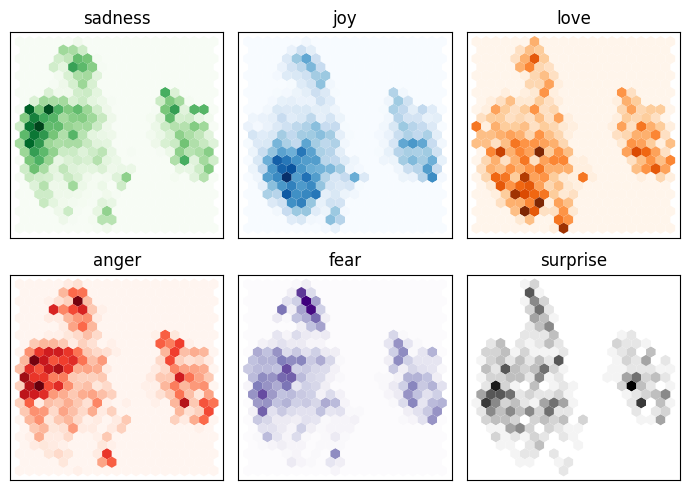

In [47]:
fig, axes = plt.subplots(2, 3, figsize=(7, 5))
axes = axes.flatten()

cmaps = ["Greens", "Blues", "Oranges", "Reds", "Purples", "Greys"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

#### Training a simple classifier

In [48]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=1000, random_state=42)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

/Users/macbook/Downloads/jupyter_env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.634

In [49]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_train, y_train)

0.335125

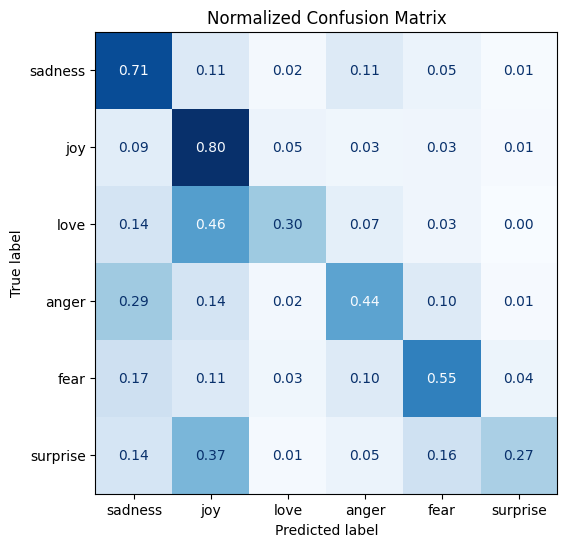

In [50]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_pred, y_true, labels):
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred, normalize="true")
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized Confusion Matrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds,y_valid, labels)

### See the Fine-Tuning Transformers Notebook